# 데이터 수집

In [2]:
# -*- coding: utf-8 -*-
"""
Books to Scrape 크롤러 (멀티스레딩 / 5페이지 / 진행상황+ETA / 이미지 다운로드)
- 상세 파싱과 동시에 표지 이미지를 data/images/ 에 저장
"""

import os
import re
import json
import time
import threading
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
from urllib.parse import urljoin, urlparse

import requests
from bs4 import BeautifulSoup
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

START_URL = "http://books.toscrape.com/catalogue/page-1.html"
HEADERS = {"User-Agent": "Mozilla/5.0"}
MAX_WORKERS = 16
PER_REQUEST_PAUSE = 0.03

DATA_DIR = Path("data")
IMAGES_DIR = DATA_DIR / "images"

print_lock = threading.Lock()

def make_session():
    s = requests.Session()
    retries = Retry(
        total=3, connect=3, read=3, backoff_factor=0.5,
        status_forcelist=(429, 500, 502, 503, 504),
        allowed_methods=frozenset(["GET"])
    )
    adapter = HTTPAdapter(max_retries=retries, pool_connections=100, pool_maxsize=100)
    s.mount("http://", adapter)
    s.mount("https://", adapter)
    s.headers.update(HEADERS)
    return s

def clean_money(s):
    return (s or "").replace("Â", "").strip()

def slugify(text, maxlen=80):
    text = re.sub(r"[^\w\s-]", "", text, flags=re.UNICODE)  # 특수문자 제거
    text = re.sub(r"[\s_-]+", "-", text).strip("-")         # 공백/언더스코어 → 하이픈
    return text[:maxlen] if text else "untitled"

def guess_ext_from_url(url, default="jpg"):
    path = urlparse(url).path
    if "." in path:
        ext = path.rsplit(".", 1)[-1].lower()
        # 간단 화이트리스트
        if ext in {"jpg", "jpeg", "png", "webp"}:
            return "jpg" if ext == "jpeg" else ext
    return default

def download_image(sess, img_url, title, upc):
    IMAGES_DIR.mkdir(parents=True, exist_ok=True)
    ext = guess_ext_from_url(img_url, default="jpg")
    name_part = (upc or slugify(title))
    filename = f"{name_part}.{ext}"
    dest = IMAGES_DIR / filename

    # 동일 파일 존재 시 중복 방지(숫자 suffix)
    if dest.exists():
        i = 2
        while True:
            cand = IMAGES_DIR / f"{name_part}-{i}.{ext}"
            if not cand.exists():
                dest = cand
                break
            i += 1

    try:
        with sess.get(img_url, timeout=20, stream=True) as r:
            r.raise_for_status()
            with open(dest, "wb") as f:
                for chunk in r.iter_content(chunk_size=8192):
                    if chunk:
                        f.write(chunk)
        return str(dest)
    except Exception as e:
        with print_lock:
            print(f"(이미지 실패) {img_url} -> {e}")
        return None

def parse_book_detail(html, base_url):
    soup = BeautifulSoup(html, "html.parser")

    details = {}
    table = soup.find("table", class_="table table-striped")
    if table:
        for row in table.find_all("tr"):
            th = row.find("th").get_text(strip=True)
            td = row.find("td").get_text(strip=True)
            details[th] = td

    title = soup.find("div", class_="product_main").find("h1").get_text(strip=True)
    desc_anchor = soup.find("div", id="product_description")
    description = desc_anchor.find_next_sibling("p").get_text(strip=True) if desc_anchor else ""

    img_tag = soup.select_one(".item.active img") or soup.find("img")
    img_rel = img_tag["src"] if img_tag else ""
    image_url = urljoin(base_url, img_rel)

    return {
        "title": title,
        "upc": details.get("UPC"),
        "product_type": details.get("Product Type", ""),
        "price_excl_tax": clean_money(details.get("Price (excl. tax)")),
        "price_incl_tax": clean_money(details.get("Price (incl. tax)")),
        "tax": clean_money(details.get("Tax")),
        "availability": details.get("Availability", ""),
        "num_reviews": details.get("Number of reviews"),
        "description": description,
        "image_url": image_url,
        "url": base_url,
    }

def get_book_details(url):
    sess = make_session()
    try:
        resp = sess.get(url, timeout=15)
        resp.raise_for_status()
        data = parse_book_detail(resp.text, url)

        # 이미지 다운로드
        img_saved_path = None
        if data.get("image_url"):
            img_saved_path = download_image(
                sess, data["image_url"], data.get("title", ""), data.get("upc")
            )
        data["image_path"] = img_saved_path

        time.sleep(PER_REQUEST_PAUSE)
        return data
    except Exception as e:
        with print_lock:
            print(f"(건너뜀) {url} -> {e}")
        return None
    finally:
        sess.close()

def collect_book_urls(start_url, max_pages=5):
    urls = []
    page_url = start_url
    page_count = 0
    sess = make_session()

    while page_url and page_count < max_pages:
        with print_lock:
            print(f"[PAGE] {page_url}")
        resp = sess.get(page_url, timeout=15)
        resp.raise_for_status()
        soup = BeautifulSoup(resp.text, "html.parser")

        for art in soup.find_all("article", class_="product_pod"):
            a = art.find("h3").find("a")
            book_rel = a["href"]
            book_url = urljoin(page_url, book_rel)
            urls.append(book_url)

        page_count += 1
        next_li = soup.find("li", class_="next")
        page_url = urljoin(page_url, next_li.find("a")["href"]) if (next_li and page_count < max_pages) else None
        time.sleep(PER_REQUEST_PAUSE)

    sess.close()
    return urls

def parse_details_multithread(book_urls, max_workers=MAX_WORKERS):
    results = []
    total = len(book_urls)
    done_cnt = 0
    start_time = time.perf_counter()

    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        fut_map = {ex.submit(get_book_details, u): u for u in book_urls}
        for fut in as_completed(fut_map):
            data = fut.result()
            if data:
                results.append(data)

            done_cnt += 1
            elapsed = time.perf_counter() - start_time
            avg_time = elapsed / max(1, done_cnt)
            eta = avg_time * (total - done_cnt)

            with print_lock:
                print(f"[PROGRESS] {done_cnt}/{total} 완료 "
                      f"({elapsed:.1f}s 경과, ETA {eta:.1f}s)")

    return results

if __name__ == "__main__":
    DATA_DIR.mkdir(parents=True, exist_ok=True)
    IMAGES_DIR.mkdir(parents=True, exist_ok=True)

    # 1) URL 수집 (5페이지 한정)
    book_urls = collect_book_urls(START_URL, max_pages=5)
    print(f"[INFO] 수집된 책 URL 수: {len(book_urls)}")

    # 2) 멀티스레드 상세 파싱(+이미지 저장)
    books = parse_details_multithread(book_urls)

    # 3) 저장 (image_path 포함)
    out_path = DATA_DIR / "books_5pages.json"
    with open(out_path, "w", encoding="utf-8") as f:
        json.dump(books, f, ensure_ascii=False, indent=2)
    print(f"Data saved to {out_path}")
    print(f"Images saved to {IMAGES_DIR}/")


[PAGE] http://books.toscrape.com/catalogue/page-1.html
[PAGE] http://books.toscrape.com/catalogue/page-2.html
[PAGE] http://books.toscrape.com/catalogue/page-3.html
[PAGE] http://books.toscrape.com/catalogue/page-4.html
[PAGE] http://books.toscrape.com/catalogue/page-5.html
[INFO] 수집된 책 URL 수: 100
[PROGRESS] 1/100 완료 (1.0s 경과, ETA 96.7s)
[PROGRESS] 2/100 완료 (1.1s 경과, ETA 51.6s)
[PROGRESS] 3/100 완료 (1.3s 경과, ETA 41.2s)
[PROGRESS] 4/100 완료 (1.7s 경과, ETA 40.0s)
[PROGRESS] 5/100 완료 (1.9s 경과, ETA 35.4s)
[PROGRESS] 6/100 완료 (2.0s 경과, ETA 31.8s)
[PROGRESS] 7/100 완료 (2.0s 경과, ETA 26.9s)
[PROGRESS] 8/100 완료 (2.2s 경과, ETA 25.2s)
[PROGRESS] 9/100 완료 (2.2s 경과, ETA 22.2s)
[PROGRESS] 10/100 완료 (2.3s 경과, ETA 20.8s)
[PROGRESS] 11/100 완료 (2.4s 경과, ETA 19.0s)
[PROGRESS] 12/100 완료 (2.4s 경과, ETA 17.3s)
[PROGRESS] 13/100 완료 (2.4s 경과, ETA 16.0s)
[PROGRESS] 14/100 완료 (2.5s 경과, ETA 15.1s)
[PROGRESS] 15/100 완료 (2.5s 경과, ETA 14.1s)
[PROGRESS] 16/100 완료 (2.6s 경과, ETA 13.5s)
[PROGRESS] 17/100 완료 (2.8s 경과, ETA 13.

# duckdb에 데이터 추가하기

## Pandas DataFrame을 DuckDB 테이블 사용하기

In [1]:
import pandas as pd
import duckdb

# 예시 Pandas DataFrame 생성
df = pd.DataFrame({
    'product': ['A', 'B', 'A', 'C', 'B'],
    'price': [1000, 2000, 1500, 3000, 2500],
    'quantity': [2, 1, 3, 1, 2]
})

# DuckDB에 연결
con = duckdb.connect(database=':memory:', read_only=False)

# DataFrame을 SQL 쿼리로 바로 사용
# SQL 내에서 DataFrame 변수명(df)을 직접 사용
result = con.execute("SELECT product, SUM(price * quantity) as total_sales FROM df GROUP BY product").fetchdf()

print(result)

# 연결 닫기
con.close()

  product  total_sales
0       C       3000.0
1       A       6500.0
2       B       7000.0


## DuckDB를 사용하여 파일 입출력 처리
- DuckDB는 CSV, Parquet, JSON 등 다양한 파일 포맷을 직접 쿼리하고 저장

In [2]:
import seaborn as sns
import pandas as pd

# 1. Seaborn에서 'iris' 데이터셋 가져오기
iris_df = sns.load_dataset('iris')

# 2. DataFrame을 'iris_data.csv' 파일로 내보내기
# index=False 옵션은 Pandas DataFrame의 인덱스를 파일에 포함시키지 않도록 합니다.
iris_df.to_csv('data/iris_data.csv', index=False)
print("DataFrame이 'iris_data.csv' 파일로 성공적으로 저장되었습니다.")

DataFrame이 'iris_data.csv' 파일로 성공적으로 저장되었습니다.


In [7]:
import duckdb

# 1. DuckDB로 파일 가져와 쿼리하기
# DuckDB에 인메모리(in-memory) 연결
con = duckdb.connect(database=':memory:', read_only=False)

# SQL 쿼리를 사용하여 CSV 파일에서 데이터 읽기
# 'iris_data.csv' 파일을 마치 테이블처럼 직접 쿼리합니다.
# species 별 sepal_length의 평균을 계산
query = """
SELECT
    species,
    AVG(sepal_length) AS avg_sepal_length
FROM 'data/iris_data.csv'
GROUP BY species
ORDER BY species;
"""

# 쿼리 실행 및 결과를 Pandas DataFrame으로 가져오기
result_df = con.execute(query).fetchdf()

# 결과 출력
print("\nDuckDB로 'iris_data.csv' 파일을 읽어온 결과:")
print(result_df)

# DuckDB 연결 종료
con.close()


DuckDB로 'iris_data.csv' 파일을 읽어온 결과:
      species  avg_sepal_length
0      setosa             5.006
1  versicolor             5.936
2   virginica             6.588


## 파일 쓰기

In [9]:
import pandas as pd
import seaborn as sns

# Seaborn에서 'iris' 데이터셋 불러오기
iris_df = sns.load_dataset('iris')

# CSV 파일로 저장
iris_df.to_csv('data/iris_to_csv_pandas.csv', index=False)
print("Pandas to_csv()로 'iris_to_csv_pandas.csv' 파일이 저장되었습니다.")

# Parquet 파일로 저장 (pyarrow 또는 fastparquet 엔진 필요)
# pip install pyarrow
iris_df.to_parquet('data/iris_to_parquet_pandas.parquet', index=False)
print("Pandas to_parquet()로 'iris_to_parquet_pandas.parquet' 파일이 저장되었습니다.")

Pandas to_csv()로 'iris_to_csv_pandas.csv' 파일이 저장되었습니다.
Pandas to_parquet()로 'iris_to_parquet_pandas.parquet' 파일이 저장되었습니다.


- CSV 파일 기반으로 COPY 명령어 사용하기
- 기존에 Pandas로 저장했던 'iris_to_csv_pandas.csv' 파일을 읽어와서 특정 조건의 데이터를 필터링한 후, 새로운 CSV 파일로 다시 저장한다. 

In [10]:
import duckdb

# DuckDB 연결
con = duckdb.connect(database=':memory:', read_only=False)

# 기존 CSV 파일 ('iris_to_csv_pandas.csv')을 읽어서 sepal_length가 5.5 이상인 데이터만 필터링
# 결과를 'filtered_iris.csv' 파일로 저장
query_from_csv = """
COPY (
    SELECT *
    FROM 'data/iris_to_csv_pandas.csv'
    WHERE "sepal_length" >= 5.5
) TO 'data/filtered_iris.csv' (HEADER, DELIMITER ',');
"""

# 쿼리 실행
con.execute(query_from_csv)
print("CSV 파일을 기반으로 DuckDB COPY 명령어가 실행되었습니다. 'filtered_iris.csv' 파일이 저장되었습니다.")

# 연결 종료
con.close()

CSV 파일을 기반으로 DuckDB COPY 명령어가 실행되었습니다. 'filtered_iris.csv' 파일이 저장되었습니다.


- Parquet 파일 기반으로 COPY 명령어 사용하기
- 기존에 Pandas로 저장했던 'data/iris_to_parquet_pandas.parquet' 파일을 읽어와서 species별로 sepal_width의 평균을 계산한 뒤, 그 결과를 Parquet 파일로 저장합니다.

In [11]:
import duckdb

# DuckDB 연결
con = duckdb.connect(database=':memory:', read_only=False)

# 기존 Parquet 파일 ('iris_to_parquet_pandas.parquet')을 읽어서 species 별 평균 sepal_width 계산
# 결과를 'avg_sepal_width.parquet' 파일로 저장
query_from_parquet = """
COPY (
    SELECT
        species,
        AVG("sepal_width") AS avg_sepal_width
    FROM 'data/iris_to_parquet_pandas.parquet'
    GROUP BY species
) TO 'data/avg_sepal_width.parquet' (FORMAT PARQUET);
"""

# 쿼리 실행
con.execute(query_from_parquet)
print("Parquet 파일을 기반으로 DuckDB COPY 명령어가 실행되었습니다. 'avg_sepal_width.parquet' 파일이 저장되었습니다.")

# 연결 종료
con.close()

Parquet 파일을 기반으로 DuckDB COPY 명령어가 실행되었습니다. 'avg_sepal_width.parquet' 파일이 저장되었습니다.


## 결과 확인

In [4]:
parquet_file_path = "data/avg_sepal_width.parquet"

pd.read_parquet(parquet_file_path)

,species,avg_sepal_width
0,versicolor,2.770
1,virginica,2.974
2,setosa,3.428


In [5]:
import duckdb

query_to_read_parquet = """
SELECT * 
FROM 'data/avg_sepal_width.parquet';
"""

con = duckdb.connect(database=':memory:', read_only=False)

con.execute(query_to_read_parquet).fetchdf()
con.close()

,species,avg_sepal_width
0,versicolor,2.770
1,virginica,2.974
2,setosa,3.428


# DuckDB에서 파일 저장된 테이블 가져오기

In [9]:
import duckdb
import pandas as pd
from pathlib import Path

# DuckDB 데이터베이스 파일 경로
DB_PATH = Path("data/books_data.duckdb")

# 데이터베이스에 연결
try:
    con = duckdb.connect(database=str(DB_PATH), read_only=True)
    
    # SQL 쿼리를 실행하여 'books_clean' 테이블의 데이터를 DataFrame으로 불러오기
    # DuckDB는 직접 DataFrame으로 결과를 반환하는 to_df() 메서드를 제공합니다.
    books_df = con.sql("SELECT * FROM books_clean").df()

    # 데이터베이스 연결 종료
    con.close()
    
    print("DuckDB에서 데이터를 성공적으로 불러와 Pandas DataFrame으로 변환했습니다.")
    print("DataFrame 정보:")
    print(type(books_df))
    books_df.info()
    
    # 상위 5개 데이터 출력하여 확인
    print("\n상위 5개 데이터:")
    print(books_df.head())

except duckdb.Error as e:
    print(f"DuckDB 연결 또는 쿼리 실행 중 오류가 발생했습니다: {e}")
except FileNotFoundError:
    print(f"오류: 데이터베이스 파일 '{DB_PATH}'을 찾을 수 없습니다.")

DuckDB에서 데이터를 성공적으로 불러와 Pandas DataFrame으로 변환했습니다.
DataFrame 정보:
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   upc             100 non-null    object 
 1   title           100 non-null    object 
 2   product_type    100 non-null    object 
 3   price_excl_tax  100 non-null    float32
 4   price_incl_tax  100 non-null    float32
 5   tax             100 non-null    float32
 6   availability    100 non-null    object 
 7   num_reviews     100 non-null    int32  
 8   description     100 non-null    object 
 9   image_url       100 non-null    object 
 10  url             100 non-null    object 
 11  image_path      100 non-null    object 
dtypes: float32(3), int32(1), object(8)
memory usage: 7.9+ KB

상위 5개 데이터:
                upc                                              title  \
0  90fa61229261

## DuckDB 테이블 삭제

In [10]:
import duckdb
import os
from pathlib import Path

# DuckDB 데이터베이스 파일 경로
DB_PATH = Path("data/books_data.duckdb")
TABLE_NAME = "books_clean"

def cleanup_duckdb():
    """
    DuckDB 파일 내의 특정 테이블과 물리적 파일을 모두 삭제합니다.
    """
    # 1. 파일 존재 여부 확인
    if not DB_PATH.exists():
        print(f"파일 '{DB_PATH}'이(가) 존재하지 않습니다. 삭제할 항목이 없습니다.")
        return

    # 2. DuckDB 파일에 연결하여 테이블 삭제
    print(f"'{DB_PATH}' 파일에 연결하여 '{TABLE_NAME}' 테이블을 삭제합니다.")
    con = None
    try:
        con = duckdb.connect(database=str(DB_PATH), read_only=False)
        con.execute(f"DROP TABLE IF EXISTS {TABLE_NAME}")
        print(f"'{TABLE_NAME}' 테이블이 성공적으로 삭제되었습니다.")
        
    except duckdb.Error as e:
        print(f"테이블 삭제 중 오류가 발생했습니다: {e}")
    finally:
        if con:
            con.close()
            print("DuckDB 연결이 종료되었습니다.")

    # 3. 물리적 파일 삭제
    print(f"물리적 파일 '{DB_PATH}'을(를) 삭제합니다.")
    try:
        os.remove(DB_PATH)
        print(f"'{DB_PATH}' 파일이 성공적으로 삭제되었습니다.")
    except OSError as e:
        print(f"물리적 파일 삭제 중 오류가 발생했습니다: {e}")

if __name__ == "__main__":
    cleanup_duckdb()

'data/books_data.duckdb' 파일에 연결하여 'books_clean' 테이블을 삭제합니다.
'books_clean' 테이블이 성공적으로 삭제되었습니다.
DuckDB 연결이 종료되었습니다.
물리적 파일 'data/books_data.duckdb'을(를) 삭제합니다.
'data/books_data.duckdb' 파일이 성공적으로 삭제되었습니다.


# Milvus 벡터 DB 입출력 예시

## 간단 예시 파일 저장

In [11]:
from pymilvus import connections, utility, FieldSchema, CollectionSchema, DataType, Collection
from pymilvus import MilvusException
import numpy as np

# Milvus 연결 설정
connections.connect(alias="default", host="localhost", port="19530")

# 컬렉션 이름 정의
COLLECTION_NAME = "hello_milvus_collection"

# 이전 컬렉션 삭제 (존재할 경우)
if utility.has_collection(COLLECTION_NAME):
    utility.drop_collection(COLLECTION_NAME)

# 컬렉션 스키마 정의
fields = [
    FieldSchema(name="book_id", dtype=DataType.INT64, is_primary=True, auto_id=False),
    FieldSchema(name="book_title", dtype=DataType.VARCHAR, max_length=200),
    FieldSchema(name="embeddings", dtype=DataType.FLOAT_VECTOR, dim=4)
]
schema = CollectionSchema(fields, "Hello Milvus")

# 컬렉션 생성
collection = Collection(name=COLLECTION_NAME, schema=schema)

# 데이터 삽입
data = [
    [1, 2, 3],
    ["The Art of War", "Pride and Prejudice", "To Kill a Mockingbird"],
    [[0.1, 0.2, 0.3, 0.4], [0.5, 0.6, 0.7, 0.8], [0.9, 1.0, 1.1, 1.2]]
]
collection.insert(data)

# 'flush()'를 호출하여 메모리의 데이터를 디스크에 동기화
collection.flush()

# 벡터 필드에 인덱스 생성
# 'IVF_FLAT' 인덱스를 사용하여 벡터 검색 준비
index_params = {
    "index_type": "IVF_FLAT",
    "metric_type": "L2",
    "params": {"nlist": 128}
}
collection.create_index(
    field_name="embeddings",
    index_params=index_params
)

# 컬렉션 로드
collection.load()

print(f"'{COLLECTION_NAME}' 컬렉션에 데이터가 성공적으로 삽입되었고, 로드되었습니다. 총 엔티티 수: {collection.num_entities}")

# 연결 해제
connections.disconnect("default")

'hello_milvus_collection' 컬렉션에 데이터가 성공적으로 삽입되었고, 로드되었습니다. 총 엔티티 수: 3


## 예시 파일 불러오기

In [12]:
from pymilvus import connections, utility, FieldSchema, CollectionSchema, DataType, Collection
from pymilvus import MilvusException
import numpy as np

# Milvus 연결 설정
connections.connect(alias="default", host="localhost", port="19530")
COLLECTION_NAME = "hello_milvus_collection"

collection = Collection(name=COLLECTION_NAME)
print(f"'{COLLECTION_NAME}' 컬렉션에 성공적으로 연결되었습니다.")

# 컬렉션이 로드되지 않았다면 로드
collection.load()
print(f"'{COLLECTION_NAME}' 컬렉션을 메모리에 로드했습니다.")

# 모든 데이터를 조회 (쿼리)
# 'book_id', 'book_title', 'embeddings' 필드 선택
# 쿼리 표현식(expr)을 "book_id > 0"으로 설정하여 모든 엔티티 조회
results = collection.query(
    expr="book_id > 0",
    output_fields=["book_id", "book_title", "embeddings"],
    consistency_level="Strong"
)

# 쿼리 결과를 Pandas DataFrame으로 변환
df = pd.DataFrame(results)

# 데이터프레임 출력
print("\n--- Pandas DataFrame ---")
print(df)
print("\n--- DataFrame 정보 ---")
df.info()

# 연결 해제
connections.disconnect("default")

'hello_milvus_collection' 컬렉션에 성공적으로 연결되었습니다.
'hello_milvus_collection' 컬렉션을 메모리에 로드했습니다.

--- Pandas DataFrame ---
              book_title                                         embeddings  \
0         The Art of War  [0.10000000149011612, 0.20000000298023224, 0.3...   
1    Pride and Prejudice  [0.5, 0.6000000238418579, 0.699999988079071, 0...   
2  To Kill a Mockingbird  [0.8999999761581421, 1.0, 1.100000023841858, 1...   

   book_id  
0        1  
1        2  
2        3  

--- DataFrame 정보 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   book_title  3 non-null      object
 1   embeddings  3 non-null      object
 2   book_id     3 non-null      int64 
dtypes: int64(1), object(2)
memory usage: 204.0+ bytes


# Milvus 이미지 벡터화 예제

이미지 다운로드 중: http://books.toscrape.com/media/cache/fe/72/fe72f0532301ec28892ae79a629a293c.jpg
이미지가 성공적으로 다운로드되어 'downloaded_image.jpg'에 저장되었습니다.
이미지 벡터화 중: downloaded_image.jpg
이미지 벡터화가 완료되었습니다. 벡터 크기: 512
Milvus 컬렉션 'book_images_vectors' 설정 완료.
벡터와 이미지 경로가 Milvus에 성공적으로 저장되었습니다.
인덱스 생성이 완료되었습니다.
Milvus에서 불러온 이미지 경로: downloaded_image.jpg
Milvus를 통해 가져온 경로의 이미지를 성공적으로 로드했습니다.
Visualizing both images...


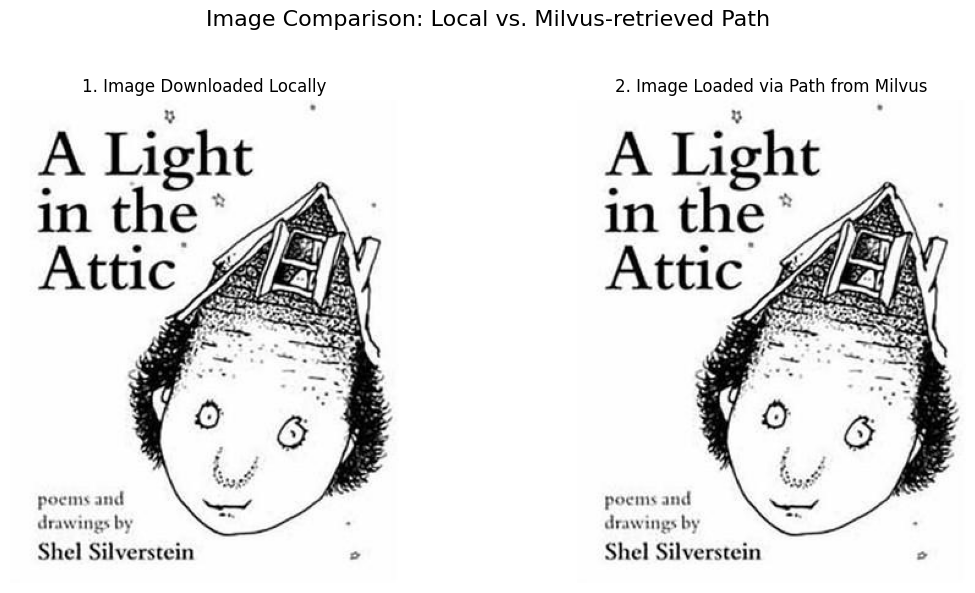

로컬 파일 'downloaded_image.jpg' 삭제 완료.


In [3]:
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pymilvus import connections, FieldSchema, CollectionSchema, Collection, DataType, utility
from sentence_transformers import SentenceTransformer

# -----------------
# Global Variables
# -----------------
MILVUS_COLLECTION_NAME = 'book_images_vectors'
IMAGE_DIMENSION = 512

def download_image(image_url: str, save_path: str) -> bool:
    """
    지정된 URL에서 이미지를 다운로드하여 로컬에 저장합니다.
    """
    print(f"이미지 다운로드 중: {image_url}")
    try:
        response = requests.get(image_url, stream=True)
        response.raise_for_status()
        with open(save_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"이미지가 성공적으로 다운로드되어 '{save_path}'에 저장되었습니다.")
        return True
    except requests.exceptions.RequestException as e:
        print(f"이미지 다운로드 중 오류가 발생했습니다: {e}")
        return False

def vectorize_image(image_path: str, model) -> np.ndarray:
    """
    로컬에 저장된 이미지를 SentenceTransformer 모델을 사용해 벡터화합니다.
    """
    print(f"이미지 벡터화 중: {image_path}")
    try:
        image = Image.open(image_path).convert("RGB")
        vector = model.encode(image)
        print(f"이미지 벡터화가 완료되었습니다. 벡터 크기: {len(vector)}")
        return vector
    except Exception as e:
        print(f"이미지 벡터화 중 오류가 발생했습니다: {e}")
        return None

def setup_milvus_collection():
    """
    Milvus 컬렉션을 설정하고 반환합니다. 컬렉션이 이미 존재하면 삭제 후 재생성합니다.
    """
    try:
        connections.connect("default", host="localhost", port="19530")
        
        fields = [
            FieldSchema(name="id", dtype=DataType.INT64, is_primary=True, auto_id=True),
            FieldSchema(name="vector", dtype=DataType.FLOAT_VECTOR, dim=IMAGE_DIMENSION),
            FieldSchema(name="image_path", dtype=DataType.VARCHAR, max_length=256)
        ]
        schema = CollectionSchema(fields, "책 이미지 벡터를 저장하는 컬렉션")
        
        if utility.has_collection(MILVUS_COLLECTION_NAME):
            Collection(MILVUS_COLLECTION_NAME).drop()
        
        collection = Collection(MILVUS_COLLECTION_NAME, schema)
        print(f"Milvus 컬렉션 '{MILVUS_COLLECTION_NAME}' 설정 완료.")
        return collection
    except Exception as e:
        print(f"Milvus 연결 또는 컬렉션 설정 중 오류가 발생했습니다: {e}")
        return None

def process_single_image_etl(image_url: str):
    """
    단일 이미지에 대한 전체 ETL(추출, 변환, 적재) 프로세스를 실행합니다.
    """
    local_image_path = 'downloaded_image.jpg'
    
    # 1. 이미지 추출 (Extract)
    if not download_image(image_url, local_image_path):
        return
    
    # Sentence-Transformers 모델 로드
    model = SentenceTransformer('clip-ViT-B-32')

    # 2. 벡터 변환 (Transform)
    vector = vectorize_image(local_image_path, model)
    if vector is None:
        os.remove(local_image_path)
        return

    # 3. Milvus에 데이터 적재 (Load)
    milvus_collection = setup_milvus_collection()
    if milvus_collection is None:
        os.remove(local_image_path)
        return

    try:
        data = [[vector], [local_image_path]]
        milvus_collection.insert(data)
        milvus_collection.flush()
        print(f"벡터와 이미지 경로가 Milvus에 성공적으로 저장되었습니다.")

        index_params = {
            "metric_type": "IP", 
            "index_type": "IVF_FLAT",
            "params": {"nlist": 128}
        }
        milvus_collection.create_index(field_name="vector", index_params=index_params)
        print("인덱스 생성이 완료되었습니다.")
        
    except Exception as e:
        print(f"데이터 적재 및 인덱스 생성 중 오류 발생: {e}")
        os.remove(local_image_path)
        return

    # 4. 저장된 데이터로 이미지 불러오기 및 시각화
    try:
        milvus_collection.load()
        results = milvus_collection.query(
            expr="id >= 0",
            output_fields=["image_path"],
            consistency_level="Strong"
        )
        
        retrieved_path = results[0]["image_path"]
        print(f"Milvus에서 불러온 이미지 경로: {retrieved_path}")
        retrieved_image = Image.open(retrieved_path)
        print("Milvus를 통해 가져온 경로의 이미지를 성공적으로 로드했습니다.")
        
        # Visualize Both Images
        print("Visualizing both images...")
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        original_image = Image.open(local_image_path)
        axes[0].imshow(original_image)
        axes[0].set_title("1. Image Downloaded Locally")
        axes[0].axis('off')

        axes[1].imshow(retrieved_image)
        axes[1].set_title("2. Image Loaded via Path from Milvus")
        axes[1].axis('off')

        plt.suptitle("Image Comparison: Local vs. Milvus-retrieved Path", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

    except Exception as e:
        print(f"이미지 불러오기 또는 시각화 중 오류가 발생했습니다: {e}")
    finally:
        if os.path.exists(local_image_path):
            os.remove(local_image_path)
            print(f"로컬 파일 '{local_image_path}' 삭제 완료.")

if __name__ == "__main__":
    # 이 부분을 수정하여 다양한 이미지를 처리할 수 있습니다.
    # 예: books.toscrape.com/media/cache/fe/72/fe72f0532301ec28892ae79a629a293c.jpg
    image_to_process = 'http://books.toscrape.com/media/cache/fe/72/fe72f0532301ec28892ae79a629a293c.jpg'
    process_single_image_etl(image_to_process)